In [1]:
# Imports
from datasets import load_dataset
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import pandas as pd
import os, json
from transformers import pipeline

In [2]:
# Visualizing the data

In [3]:
dataset = load_dataset("generative-newsai/news-unmasked")

Found cached dataset parquet (/Users/swapnilsharma/.cache/huggingface/datasets/generative-newsai___parquet/generative-newsai--news-unmasked-afc734a91f0700d7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
train = dataset["train"]
test = dataset["test"]

In [5]:
train.__len__(), test.__len__()

(48988, 12247)

In [6]:
train.features, test.features

({'image': Image(decode=True, id=None),
  'section': Value(dtype='string', id=None),
  'headline': Value(dtype='string', id=None),
  'image_id': Value(dtype='string', id=None)},
 {'image': Image(decode=True, id=None),
  'section': Value(dtype='string', id=None),
  'headline': Value(dtype='string', id=None),
  'image_id': Value(dtype='string', id=None)})

In [7]:
train[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x295>,
 'section': 'Education',
 'headline': "Role for Teachers Is Seen in Solving Schools ' Crises",
 'image_id': '000055fd-f997-57a0-b586-49eaf0d930fc'}

In [8]:
test[random.choice(range(test.__len__()))]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1050x550>,
 'section': 'Media',
 'headline': 'Kevin Hart to Publish Memoir Next Year',
 'image_id': 'ee7f7543-3f58-5fa6-af49-ae76cd12c52f'}

In [9]:
# how many test headlines have [MASK] in them?
mask_token = "[MASK]"
test_with_mask = [x for x in test["headline"] if mask_token in x]
print(f"{len(test_with_mask)} out of {len(test)} test headlines have [MASK] in them")

5701 out of 12247 test headlines have [MASK] in them


In [10]:
# how many train headlines have [MASK] in them?
train_with_mask = [x for x in train["headline"] if mask_token in x]
print(f"{len(train_with_mask)} out of {len(train)} train headlines have [MASK] in them")

0 out of 48988 train headlines have [MASK] in them


In [11]:
sections = np.unique(train["section"])
print("Unique sections in the dataset: ", len(sections))

Unique sections in the dataset:  24


Observations: Not all the test entries have [MASK] token in them and there are 24 unique sections in the dataset.

## Plot section count

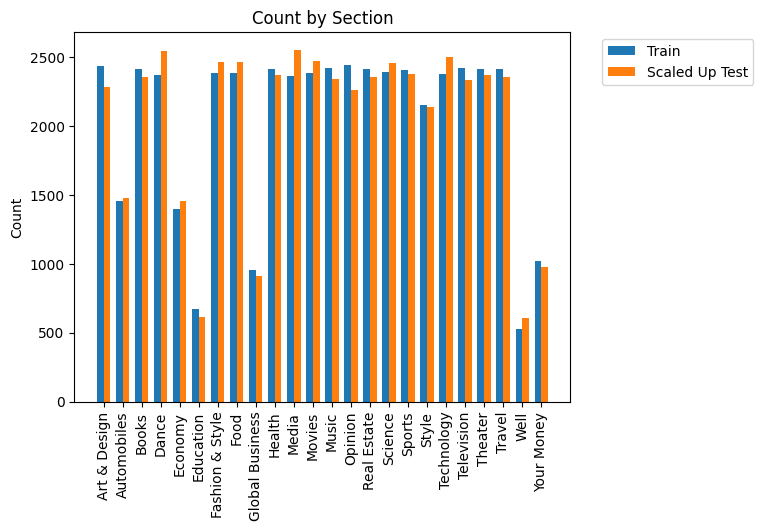

In [12]:
# Plot np unique with counts
z_train = np.unique(train["section"], return_counts=True)
z_test = np.unique(test["section"], return_counts=True)

# np unique returns sorted unique elements
assert np.array_equal(z_train[0], z_test[0])

# plot grouped bar chart
fig, ax = plt.subplots()
x = np.arange(len(z_train[0]))
width = 0.35
rects1 = ax.bar(x - width / 2, z_train[1], width, label="Train")
rects2 = ax.bar(x + width / 2, z_test[1]*(train.__len__()/test.__len__()), width, label="Scaled Up Test")
ax.set_ylabel("Count")
ax.set_title("Count by Section")
ax.set_xticks(x)
ax.set_xticklabels(z_train[0])
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=90)
plt.show()

Observations: We have 24 unique sections with Well, Education, Global Business, Your Money, Economy and Automobiles having lowest occurence. Train dataset and test dataset follow similar pattern for section distribution

## Plot headline length by section

In [13]:
# Group headline_length_per_section by section
from itertools import groupby

def groupby_section(dataset):
    ln_per_section = list(zip(dataset["section"], [len(headline) for headline in dataset["headline"]]))
    ln_per_section = sorted(ln_per_section, key=lambda x: x[0])
    ln_per_section = [(key, list(group)) for key, group in groupby(ln_per_section, lambda x: x[0])]
    ln_per_section = [(key, [x[1] for x in group]) for key, group in ln_per_section]
    ln_stats_per_section = [(key, np.mean(group), np.std(group)) for key, group in ln_per_section]
    return ln_stats_per_section

train_ln_stats_per_section = groupby_section(train)
test_ln_stats_per_section = groupby_section(test)

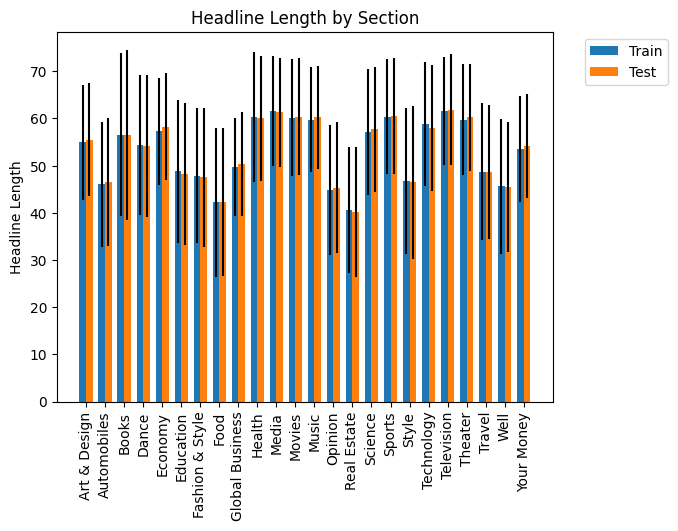

In [14]:
# Plot train_ln_stats_per_section and test_ln_stats_per_section as grouped bar chart with error bars
fig, ax = plt.subplots()
x = np.arange(len(train_ln_stats_per_section))
width = 0.35
rects1 = ax.bar(x - width / 2, [x[1] for x in train_ln_stats_per_section], width, yerr=[x[2] for x in train_ln_stats_per_section], label="Train")
rects2 = ax.bar(x + width / 2, [x[1] for x in test_ln_stats_per_section], width, yerr=[x[2] for x in test_ln_stats_per_section], label="Test")
ax.set_ylabel("Headline Length")
ax.set_title("Headline Length by Section")
ax.set_xticks(x)
ax.set_xticklabels([x[0] for x in train_ln_stats_per_section])
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=90)
plt.show()


Observations: No outliers in headline length. We can see that the length of the headline is similar across all sections and lies between ~30 to ~80 characters.

## Sample images

Uncomment to visualize

In [15]:
imgs = []
for i, section in enumerate(tqdm(sections)):
    indices = random.choices(np.where(np.asarray(train["section"]) == section)[0], k=5)
    imgs.append(train[indices]["image"])

100%|██████████| 24/24 [00:01<00:00, 12.64it/s]


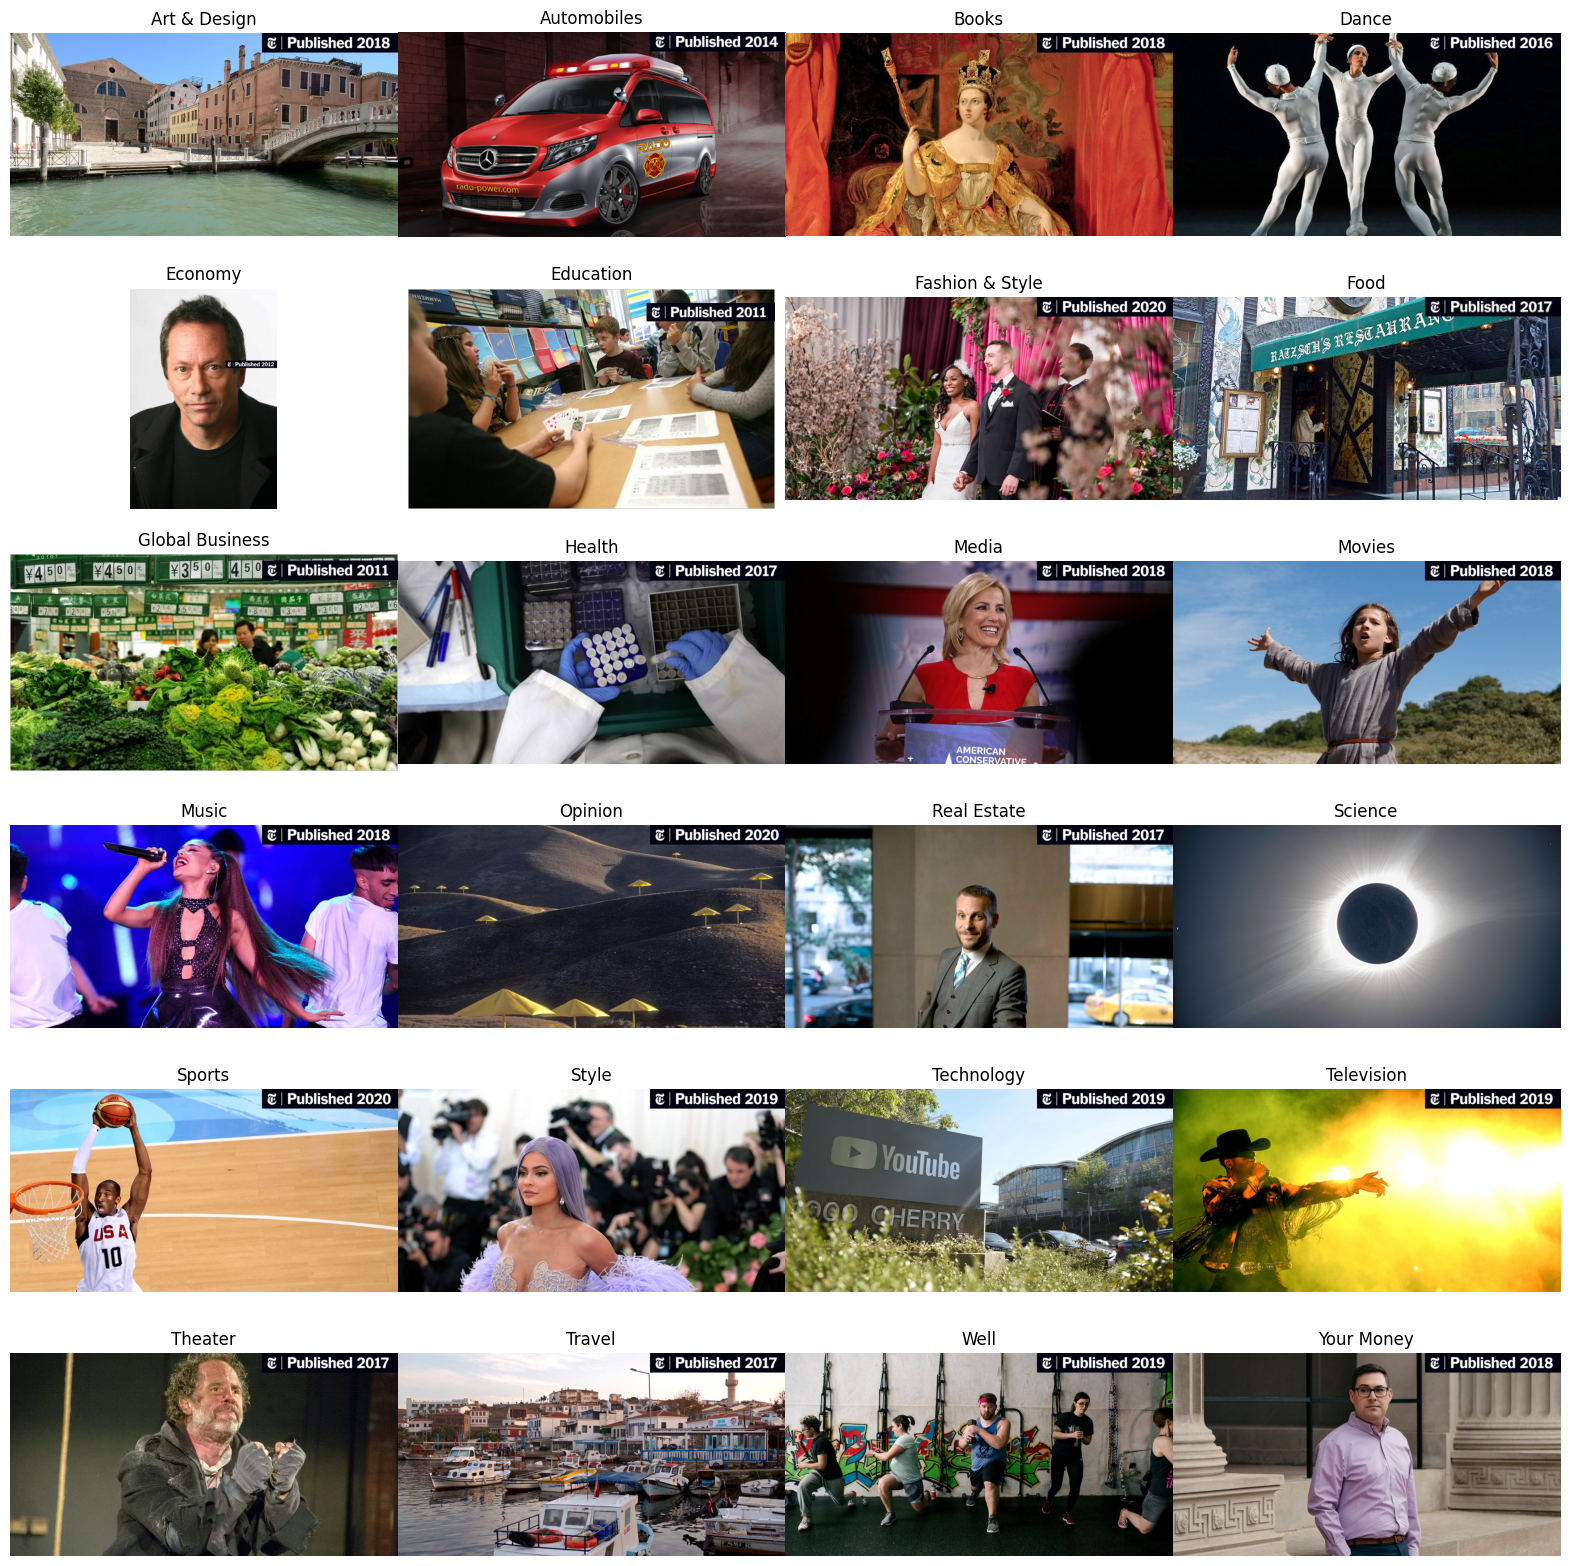

In [16]:
# Plot images for each section
fig, axs = plt.subplots(6, 4, figsize=(20, 20))
for i, ax in enumerate(axs.flat):
    ax.imshow(imgs[i][random.randint(0, 4)])
    ax.set_title(sections[i])
    ax.axis("off")
plt.subplots_adjust(wspace=0)
plt.show()

In [17]:
[img.size for img in train[random.sample(range(train.__len__()), 10)]["image"]]

[(1050, 550),
 (1050, 550),
 (1050, 550),
 (600, 438),
 (1050, 549),
 (1050, 550),
 (1050, 550),
 (1050, 550),
 (1050, 549),
 (1050, 550)]

Observations: Visualized Images have nytimes labeel showing what year it was printed, and sizes vary across images

# Deberta-Base-Uncased

Based on the sample notebook provided --> https://huggingface.co/datasets/generative-newsai/news-unmasked/blob/main/.extras/helper_notebook.ipynb

In [18]:
model_name = "mlcorelib/deberta-base-uncased"
unmasker = pipeline('fill-mask', model=model_name)

Some weights of the model checkpoint at mlcorelib/deberta-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Check first 5 rows of the Test dataset

In [34]:
# Check first 5 rows of the test dataset
sample_data = test[:5]
for k, v in sample_data.items():
    print("-"*50)
    print(k)
    print(*v, sep="\n")

--------------------------------------------------
image
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1050x550 at 0x16524A590>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1050x550 at 0x16531EA40>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=789x412 at 0x16524A710>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1050x549 at 0x16524A5F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1050x550 at 0x16524A6E0>
--------------------------------------------------
section
Television
Sports
Television
Technology
Fashion & Style
--------------------------------------------------
headline
What 's on TV Monday : ' The Voice ' and ' Gentefied '
Phillies - Blue Jays Games Postponed After 2 Staff Members Test [MASK]
Joe Biden 's Run Has [MASK] Night Looking for a Fight
Pinterest Posts [MASK] Loss , but Falls Short of Wall St. Estimates
Yolanda Foster : Watching Her Daughter Gigi Hadid From the Front Row
--------------------------------------------------
ima

## Unmask the sentences

In [19]:
all_masked_words = []
for each_dict in tqdm(test):
    sentence = each_dict['headline']  # Get the sentence from the dictionary
    image_id = each_dict['image_id']  # Get the image_id from the dictionary
    if "[MASK]" in sentence: # See if it has a [MASK] in headline
        result = unmasker(sentence)  # Unmask the sentence

        # Make a list of indices where [MASK] is present in the sentence
        # If there are more than one [MASK] in the sentence, then add them as separate entries in the result list
        indices = [i for i, x in enumerate(sentence.split()) if x == "[MASK]"]
        if len(indices) > 1:
            masked_word_idx_list = []
            for i, each_result in enumerate(result):
                # Get the top scoring word
                top_word = each_result[0]['token_str']
                all_masked_words.append([image_id, indices[i], top_word])
        else:
            all_masked_words.append([image_id, indices[0], result[0]['token_str']])

final_masked_words = [l[0] for l in all_masked_words]

100%|██████████| 12247/12247 [07:19<00:00, 27.87it/s]


## Print first 5 rows of the masked words list

In [20]:
print(final_masked_words[:5])

['00040f12-c19e-54db-9513-d4a3d9ce30f1', '0006d6e6-a16f-5d69-a307-0e7e1b659075', '000755c6-df96-502a-a3e4-8f78f0919a8c', '0038ee8b-3f57-5838-a201-509d4bcd1c06', '0048f974-e081-54ee-b0c4-e30b5f66c763']


## Save the results as a dataframe and print first 5 rows of the dataframe

In [21]:
# Save the results in a dataframe with column name id,token_index,token
df = pd.DataFrame(all_masked_words, columns=['id', 'token_index', 'token'])
df.head()

id  token_index    token
0  00040f12-c19e-54db-9513-d4a3d9ce30f1           11        .
1  0006d6e6-a16f-5d69-a307-0e7e1b659075            5      the
2  000755c6-df96-502a-a3e4-8f78f0919a8c            2        a
3  0038ee8b-3f57-5838-a201-509d4bcd1c06            0  regular
4  0048f974-e081-54ee-b0c4-e30b5f66c763            6        a

## Save the dataframe as a csv file

In [ ]:
df.to_csv('sample_result.csv', index=False)